# 作业4：离群点分析与异常检测

###### author：李杨晓           

https://github.com/Catherine134/DataAnalysis_Task

#### 摘要：
    
    *数据集：1.wine  2.skin
    *工具：pyod   
    *方法：Model 1 PCA
           Model 2 MCD
           Model 3 OCSVM
           Model 4 LOF
           Model 5 CBLOF
           Model 6 HBOS
           Model 7 KNN
           Model 8 AvgKNN
           Model 9 MedKNN
           Model 10 ABOD
           Model 11 IForest
           Model 12 FB     
    *评估：roc/auc & precision
    *对比：各模型在所有文件上的得分取平均

In [49]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from sklearn import model_selection
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.metrics import roc_auc_score
from pyod.utils.utility import precision_n_scores

In [69]:
# Define nine outlier detection tools to be compared
outliers_fraction = 0.25
random_state = 42

classifiers = {
    "PCA":PCA(contamination=outliers_fraction, random_state=random_state),
    "MCD":MCD(contamination=outliers_fraction, random_state=random_state),
    "OCSVM":OCSVM(contamination=outliers_fraction),
    "LOF":LOF(n_neighbors=35, contamination=outliers_fraction),
    "CBLOF":CBLOF(contamination=outliers_fraction, check_estimator=False, random_state=random_state),
    "HBOS":HBOS(contamination=outliers_fraction),
    "KNN":KNN(contamination=outliers_fraction),
    "AvgKNN": KNN(method='mean',contamination=outliers_fraction),
    "MedKNN": KNN(method='median',contamination=outliers_fraction), 
    "ABOD":ABOD(contamination=outliers_fraction),
    "IForest":IForest(contamination=outliers_fraction, random_state=random_state),
    "FB":FeatureBagging(LOF(n_neighbors=35), check_estimator=False, random_state=random_state)
}

# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 PCA
Model 2 MCD
Model 3 OCSVM
Model 4 LOF
Model 5 CBLOF
Model 6 HBOS
Model 7 KNN
Model 8 AvgKNN
Model 9 MedKNN
Model 10 ABOD
Model 11 IForest
Model 12 FB


本次实验选取的模型如上。

## 1.wine-benchmark

In [51]:
#读取benchmark数据集
path = "data/wine/benchmarks/"
files = []
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    files.append(file_path)
    
num_files = len(files)
num_files

1210

In [4]:
df0 = pd.read_csv(files[0])
df0.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


In [5]:
df5 = pd.read_csv(files[5])
df5.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,...,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,noise..1,noise..2,noise..3,noise..4
0,wine_point_1337,wine,regression,8,0.068979,nominal,0.451001,-0.301671,0.284664,0.327202,...,0.421123,0.800671,-0.198966,0.258100,-1.083749,0.593772,0.422293,0.598458,-1.466193,0.682405
1,wine_point_1330,wine,regression,5,0.124966,anomaly,0.913809,-0.909070,0.766367,-0.702685,...,-0.592996,-0.207788,-0.232314,-2.291854,-0.478935,-0.831551,0.835181,1.369147,-0.979311,2.379368
2,wine_point_5987,wine,regression,7,0.069402,nominal,3.382119,0.427208,1.523328,-0.828793,...,-0.480316,-1.322401,0.884847,-1.234556,1.537115,-0.496181,1.179255,-0.400583,0.654745,0.065328
3,wine_point_1709,wine,regression,4,0.105530,anomaly,-0.166076,1.642006,-0.403482,-0.786757,...,-0.311296,0.800671,-0.032226,0.880040,0.461889,0.090717,3.037251,-0.486215,-0.705857,-0.166076
4,wine_point_0108,wine,regression,6,0.106263,nominal,-0.088942,-0.666110,0.215849,2.323922,...,1.660602,0.977594,1.435090,-0.363840,0.394687,-1.166921,0.697552,-0.714567,-0.979311,4.153466


##### wine数据集分析

随机选取2个benchmark数据，通过观察对比可以发现：

·不同的抽样子数据集都对样本点的离群与否做出了标注（groud.truth属性值）。

·尽管不同的benchmark文件中的属性个数不同，但它们具有一些相同属性，这些属性是后续训练模型时的重要特征。

In [70]:
# roc与prn字典，存储模型评估结果
roc_wine = {
    'PCA': [],
    'MCD': [],
    'OCSVM': [],
    'LOF': [],
    'CBLOF': [],
    'HBOS': [],
    'KNN': [],
    'AvgKNN': [],
    'MedKNN': [],
    'ABOD': [],
    'IForest': [],
    'FB': []
}

prn_wine = {
    'PCA': [],
    'MCD': [],
    'OCSVM': [],
    'LOF': [],
    'CBLOF': [],
    'HBOS': [],
    'KNN': [],
    'AvgKNN': [],
    'MedKNN': [],
    'ABOD': [],
    'IForest': [],
    'FB': []
}

In [71]:
#遍历数据集
for file in range(num_files):
    
    df = pd.read_csv(files[file])
    
    #特征选取
    X = df[[ 'fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
            'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
            'pH', 'sulphates', 'alcohol']].values
    Y = np.where(df["ground.truth"] == "nominal" , 0 ,1)
    
    #划分训练集与测试集
    x_train, x_test, y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2,random_state=random_state)
    
    #使用不同方法
    for clf_name, clf in classifiers.items():
        #fit the model
        clf.fit(x_train)

        # get outlier scores
        y_train_scores = clf.decision_scores_  # raw outlier scores
        y_test_scores = clf.decision_function(x_test)  # outlier scores

        y = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)

        #evaluate
        try:
            roc = np.round(roc_auc_score(y, y_pred), decimals=4)
            prn = np.round(precision_n_scores(y, y_pred), decimals=4)
        except ValueError:
            pass
        
        roc_wine[clf_name].append(roc)
        prn_wine[clf_name].append(prn)

In [74]:
#将模型评估值转为df 并写入文件
wine_roc = pd.DataFrame()
wine_prn = pd.DataFrame()

roc_list = list(roc_wine.values())
prn_list = list(prn_wine.values())

for i, clf in enumerate(classifiers.keys()):
    wine_roc.loc[:,clf] = roc_list[i]
    wine_prn.loc[:,clf] = prn_list[i]
    
wine_roc.to_csv('wine_roc.csv')
wine_prn.to_csv('wine_prn.csv')

In [75]:
#查看结果
wine_roc

,PCA,MCD,OCSVM,LOF,CBLOF,HBOS,KNN,AvgKNN,MedKNN,ABOD,IForest,FB
0,0.5252,0.6218,0.5258,0.5233,0.5442,0.5279,0.5231,0.5124,0.5190,0.5190,0.5249,0.5327
1,0.5284,0.6042,0.5233,0.5504,0.5536,0.5269,0.5454,0.5523,0.5378,0.5378,0.5282,0.5528
2,0.5270,0.5955,0.5276,0.5469,0.5528,0.5464,0.5457,0.5549,0.5502,0.5502,0.5425,0.5512
3,0.5571,0.6231,0.5475,0.5576,0.5536,0.5847,0.5481,0.5244,0.5419,0.5419,0.5502,0.5532
4,0.5696,0.6289,0.5547,0.5615,0.5594,0.5776,0.5715,0.5681,0.5581,0.5581,0.5540,0.5692
...,...,...,...,...,...,...,...,...,...,...,...,...
1205,0.5468,0.5733,0.5384,0.5419,0.5274,0.5698,0.5365,0.5706,0.5491,0.5491,0.5676,0.5402
1206,0.5611,0.5953,0.5573,0.5596,0.5839,0.5935,0.5559,0.5839,0.5552,0.5552,0.5592,0.5569
1207,0.5164,0.5566,0.5054,0.5191,0.5530,0.5056,0.5488,0.5841,0.5510,0.5510,0.5213,0.5335
1208,0.5293,0.5818,0.5119,0.5522,0.5496,0.5353,0.5539,0.5758,0.5483,0.5483,0.5586,0.5649


In [100]:
#各种方法在所有子数据集上的roc求均值
wine_roc.mean()

PCA        0.566678
MCD        0.606792
OCSVM      0.563928
LOF        0.578963
CBLOF      0.579803
HBOS       0.573383
KNN        0.587674
AvgKNN     0.611787
MedKNN     0.590633
ABOD       0.590090
IForest    0.571033
FB         0.579194
dtype: float64

In [76]:
#查看结果
wine_prn

,PCA,MCD,OCSVM,LOF,CBLOF,HBOS,KNN,AvgKNN,MedKNN,ABOD,IForest,FB
0,0.3898,0.4449,0.3834,0.3755,0.3898,0.3898,0.3701,0.3622,0.3937,0.3937,0.3701,0.3780
1,0.3720,0.4320,0.3520,0.3720,0.3960,0.3800,0.3534,0.3840,0.3574,0.3574,0.3680,0.3560
2,0.4086,0.4839,0.4158,0.4014,0.4444,0.4194,0.4265,0.4158,0.4265,0.4265,0.4158,0.4122
3,0.4228,0.4853,0.4118,0.4191,0.4118,0.4412,0.4007,0.3824,0.3860,0.3860,0.4081,0.4191
4,0.4318,0.4811,0.4015,0.4280,0.4205,0.4356,0.4394,0.4280,0.4205,0.4205,0.4129,0.4091
...,...,...,...,...,...,...,...,...,...,...,...,...
1205,0.1286,0.1143,0.1000,0.0571,0.0714,0.1143,0.0714,0.0714,0.0571,0.0571,0.1000,0.0571
1206,0.1304,0.1159,0.1159,0.1014,0.1159,0.1159,0.0725,0.1449,0.1014,0.1014,0.1159,0.1014
1207,0.0909,0.1250,0.0568,0.0682,0.0682,0.0682,0.0795,0.0795,0.0795,0.0795,0.0568,0.0795
1208,0.1266,0.1519,0.0886,0.0759,0.1139,0.0759,0.1013,0.1013,0.0886,0.0886,0.1266,0.0633


In [101]:
#各种方法在所有子数据集上的prn求均值
wine_prn.mean()

PCA        0.154649
MCD        0.167814
OCSVM      0.151922
LOF        0.157486
CBLOF      0.155540
HBOS       0.150644
KNN        0.161929
AvgKNN     0.166315
MedKNN     0.163198
ABOD       0.162264
IForest    0.153566
FB         0.160003
dtype: float64

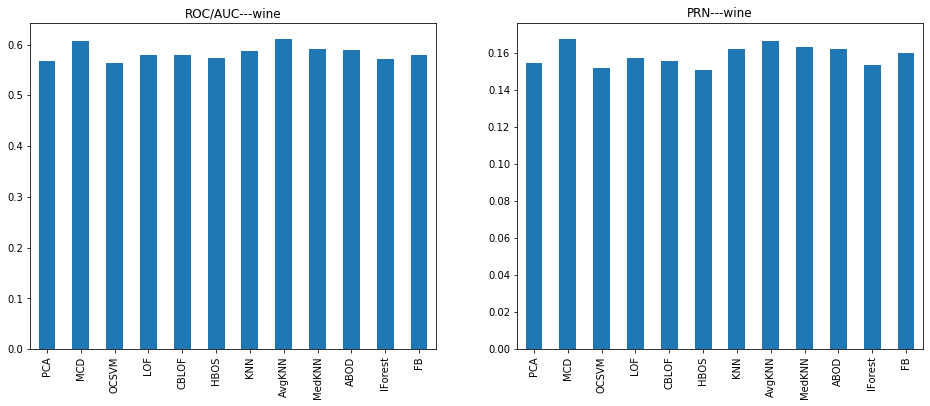

In [114]:
#各模型评估结果可视化
plt.figure(figsize=(16,6))
plt.subplots_adjust(hspace=0.7)

plt.subplot(1,2,1)
plt.title('ROC/AUC---wine')
wine_roc.mean().plot.bar() 

plt.subplot(1,2,2)
plt.title('PRN---wine')
wine_prn.mean().plot.bar() 

##### 结果分析：

上图反映了12种模型在wine-benchmark数据集上的平均表现。

·1.通过对比可以看出，线性模型中的MCD，以及基于临近度的AvgKNN，在本次实验中取得了较好的表现。

·2.就KNN及其两种变体而言，在所有模型中的表现相对来说算是鲁棒性较好的。

·3.所有模型的检测效果差异并不悬殊，在全部benchmark数据上的评估值取平均后就比较接近了。

·4.然而，整体的ROC/AUC值以及precision值都不算理想，原因及改进方法还在进一步探索中。

·5.在探索原因的过程中，笔者尝试了将输出分数进行标准化，但改进后的结果与当前差异不大，效果并不显著。

## 2.skin-benchmark

In [102]:
#读取benchmark数据集
path = "data/skin/benchmarks/"
files = []
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    files.append(file_path)
    
num_files = len(files)
num_files

1500

In [103]:
df0 = pd.read_csv(files[0])
df0.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
1,skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
2,skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
3,skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
4,skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


In [104]:
df5 = pd.read_csv(files[5])
df5.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B,noise..1
0,skin_point_192902,skin,binary,2,0.000659,nominal,1.171533,1.059249,0.521248,-0.333192
1,skin_point_044700,skin,binary,1,0.001361,anomaly,-0.386558,0.091634,1.031155,-0.856881
2,skin_point_085015,skin,binary,2,0.000749,nominal,1.219721,1.125981,0.535029,1.058718
3,skin_point_042604,skin,binary,1,0.622567,anomaly,-0.466872,0.008219,1.072499,0.080246
4,skin_point_148382,skin,binary,2,0.003467,nominal,0.079263,0.024902,-0.415880,-1.353007


##### skin数据集分析

这里的分析过程与wine数据集相同，一样是选取各benchmark数据文件中的公共列，即R、G、B作为特征。

In [106]:
# roc与prn字典，存储模型评估结果
roc_skin = {
    'PCA': [],
    'MCD': [],
    'OCSVM': [],
    'LOF': [],
    'CBLOF': [],
    'HBOS': [],
    'KNN': [],
    'AvgKNN': [],
    'MedKNN': [],
    'ABOD': [],
    'IForest': [],
    'FB': []
}

prn_skin = {
    'PCA': [],
    'MCD': [],
    'OCSVM': [],
    'LOF': [],
    'CBLOF': [],
    'HBOS': [],
    'KNN': [],
    'AvgKNN': [],
    'MedKNN': [],
    'ABOD': [],
    'IForest': [],
    'FB': []
}

In [107]:
#遍历数据集
for file in range(num_files):
    
    df = pd.read_csv(files[file])
    
    #特征选取
    X = df[[ 'R', 'G', 'B']].values
    Y = np.where(df["ground.truth"] == "nominal" , 0 ,1)
    
    #划分训练集与测试集
    x_train, x_test, y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2,random_state=random_state)
    
    #使用不同方法
    for clf_name, clf in classifiers.items():
        #fit the model
        clf.fit(x_train)

        # get outlier scores
        y_train_scores = clf.decision_scores_  # raw outlier scores
        y_test_scores = clf.decision_function(x_test)  # outlier scores

        y = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)

        #evaluate
        try:
            roc = np.round(roc_auc_score(y, y_pred), decimals=4)
            prn = np.round(precision_n_scores(y, y_pred), decimals=4)
        except ValueError:
            pass
        
        roc_skin[clf_name].append(roc)
        prn_skin[clf_name].append(prn)

In [109]:
#将模型评估值转为df 并写入文件
skin_roc = pd.DataFrame()
skin_prn = pd.DataFrame()

roc_list = list(roc_skin.values())
prn_list = list(prn_skin.values())

for i, clf in enumerate(classifiers.keys()):
    skin_roc.loc[:,clf] = roc_list[i]
    skin_prn.loc[:,clf] = prn_list[i]
    
skin_roc.to_csv('skin_roc.csv')
skin_prn.to_csv('skin_prn.csv')

In [115]:
#查看结果
skin_roc

,PCA,MCD,OCSVM,LOF,CBLOF,HBOS,KNN,AvgKNN,MedKNN,ABOD,IForest,FB
0,0.4485,0.8897,0.5616,0.3576,0.6165,0.6002,0.7044,0.6978,0.7010,0.7010,0.6643,0.4225
1,0.4494,0.8803,0.5241,0.3506,0.6555,0.5471,0.7047,0.6997,0.7047,0.7047,0.6650,0.3977
2,0.4310,0.8957,0.5293,0.3809,0.6878,0.6026,0.7431,0.7335,0.7276,0.7276,0.6800,0.4565
3,0.4473,0.9056,0.5636,0.4037,0.6702,0.6172,0.7488,0.7431,0.7439,0.7439,0.6629,0.4357
4,0.4702,0.9015,0.5914,0.4006,0.7255,0.6152,0.7396,0.7397,0.7420,0.7420,0.6902,0.4678
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.2352,0.2881,0.2468,0.4598,0.5367,0.3252,0.4731,0.4541,0.4590,0.4590,0.3459,0.4625
1496,0.2096,0.4771,0.2688,0.4615,0.5368,0.3269,0.4953,0.4896,0.4928,0.4928,0.3928,0.4717
1497,0.2231,0.3130,0.2534,0.4951,0.5641,0.3633,0.4861,0.4726,0.4774,0.4774,0.3767,0.4895
1498,0.1749,0.5008,0.2363,0.4250,0.5293,0.3205,0.4640,0.4343,0.4280,0.4280,0.3248,0.3772


In [112]:
#各种方法在所有子数据集上的roc求均值
skin_roc.mean()

PCA        0.508612
MCD        0.741139
OCSVM      0.633074
LOF        0.554544
CBLOF      0.730949
HBOS       0.596712
KNN        0.759749
AvgKNN     0.756529
MedKNN     0.754988
ABOD       0.755000
IForest    0.685622
FB         0.603309
dtype: float64

In [116]:
#查看结果
skin_prn

,PCA,MCD,OCSVM,LOF,CBLOF,HBOS,KNN,AvgKNN,MedKNN,ABOD,IForest,FB
0,0.0333,0.5625,0.1958,0.0833,0.2708,0.1674,0.2042,0.2333,0.2292,0.2292,0.0750,0.1667
1,0.0283,0.5344,0.1377,0.0810,0.3279,0.1660,0.2105,0.2065,0.2389,0.2389,0.0688,0.1296
2,0.0484,0.5847,0.2218,0.0612,0.3589,0.2097,0.2863,0.2984,0.2955,0.2955,0.1532,0.1532
3,0.0121,0.6290,0.2460,0.1089,0.3266,0.1815,0.2661,0.2944,0.2984,0.2984,0.1008,0.1129
4,0.0415,0.6100,0.2573,0.0871,0.3983,0.1542,0.2656,0.2822,0.2988,0.2988,0.1162,0.1535
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0000,0.0000,0.0000,0.0354,0.0000,0.0089,0.0177,0.0265,0.0354,0.0354,0.0000,0.0796
1496,0.0000,0.0000,0.0000,0.0078,0.0078,0.0000,0.0078,0.0078,0.0155,0.0155,0.0078,0.0465
1497,0.0075,0.0000,0.0000,0.0301,0.0526,0.0000,0.0301,0.0376,0.0526,0.0526,0.0226,0.0376
1498,0.0000,0.0000,0.0000,0.0250,0.0000,0.0000,0.0167,0.0333,0.0583,0.0583,0.0000,0.0250


In [111]:
#各种方法在所有子数据集上的prn求均值
skin_prn.mean()

PCA        0.060819
MCD        0.098941
OCSVM      0.063833
LOF        0.052486
CBLOF      0.092276
HBOS       0.063837
KNN        0.082150
AvgKNN     0.086907
MedKNN     0.090427
ABOD       0.090441
IForest    0.055127
FB         0.073405
dtype: float64

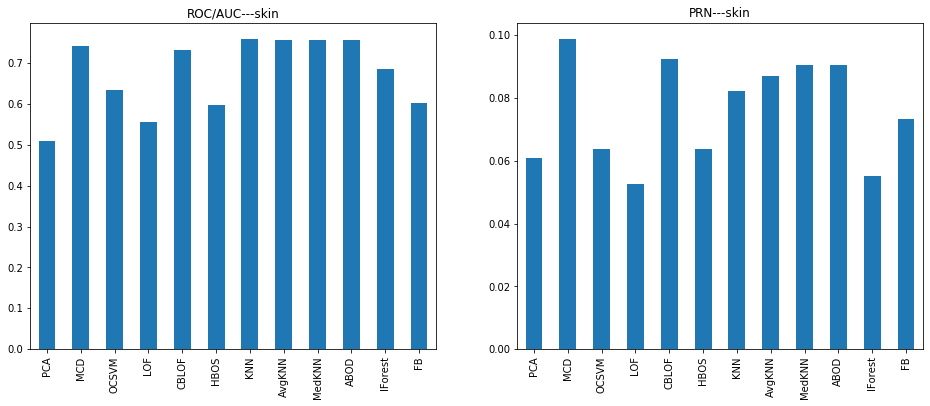

In [113]:
#各模型评估结果可视化
plt.figure(figsize=(16,6))
plt.subplots_adjust(hspace=0.7)

plt.subplot(1,2,1)
plt.title('ROC/AUC---skin')
skin_roc.mean().plot.bar() 

plt.subplot(1,2,2)
plt.title('PRN---skin')
skin_prn.mean().plot.bar() 

##### 结果分析

上图反映了12种模型在skin-benchmark数据集上的平均表现：

·1.从柱状图种可以看出，skin数据集与第一个数据集wine很不同的一点是，所有模型的评估结果差异是非常明显的。

·2.同样地，线性模型中的MCD，以及基于临近度的KNN系列方法，它们的表现仍是相对来说比较不错的。

·3.基于临近度的CBLOF模型的优势在skin数据集中也突显了出来，其结果明显超过了多种其他方法。

·4.在skin数据集上，多数模型的ruc/auc值有明显提升，但precision值下降了较多。推测这可能是由于提供的特征数较少的原因。